In [7]:
import pandas as pd
import keras
import tensorflow as tf
import numpy as np
import scipy.io
from PIL import Image
import cv2
import matplotlib.pyplot as plt

### Data Understanding
images    -- train, val, test. Normal looking images

maps      -- train, val. grayscale points of attention 

fixations -- train, val, test.



In [4]:
# All pathing goes here

root_dir = '/home/babeen/Documents/Image Saliency Cropping/'
images_path = root_dir + 'images/'
maps_path = root_dir + 'maps/'
fixation_path = root_dir + 'fixations/'

images_train = images_path + 'train/'
images_val = images_path + 'val/'
images_test = images_path + 'test/'

maps_train = maps_path + 'train/'
maps_val = maps_path + 'val/'

fixations_train = fixation_path + 'train/'
fixations_val = fixation_path + 'val/'
fixations_test = fixation_path + 'test/'

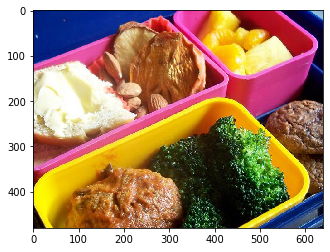

In [9]:
mat = fixations_train + 'COCO_train2014_000000000009.mat'
img = images_train + 'COCO_train2014_000000000009.jpg'
mat = scipy.io.loadmat(mat)['gaze']
img = cv2.imread(img)

for item in mat:
    item = item[0]
    location_of_gaze = item[0]
    timestamp_of_each_gaze_point = item[1]
    fixations_points = item[2]
    
plt.imshow(img[:, :, ::-1])